## project 

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score




In [4]:
from bs4 import BeautifulSoup
import requests

url = 'http://www.econometrics.com/intro/sales.htm'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page, "lxml")

for node in soup.findAll('pre'):
    l = []
    l.append(''.join(node.findAll(text=True)))
    
import pandas as pd
df = pd.read_csv('book4.csv')    
    

In [8]:
df.columns = ['Sales', 'Advertising']

In [10]:
checks
#df
#print(df.describe())
#print(df.info())

In [58]:
X = df['Sales'].values
y = df['Advertising'].values

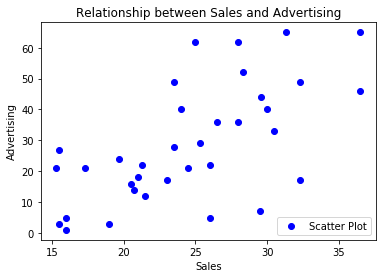

In [59]:
plt.scatter(X, y, color = 'blue', label='Scatter Plot')
plt.title('Relationship between Sales and Advertising')
plt.xlabel('Sales')
plt.ylabel('Advertising')
plt.legend(loc=4)
plt.show()

In [60]:
X = X.reshape(-1,1)
y = y.reshape(-1,1)

print(X.shape)
print(y.shape)

(35, 1)
(35, 1)


In [61]:
df.corr()

,Sales,Advertising
Sales,1.000000,0.635931
Advertising,0.635931,1.000000


In [62]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('Advertising ~Sales', data=df, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Advertising   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     22.41
Date:                Fri, 11 Oct 2019   Prob (F-statistic):           4.04e-05
Time:                        00:49:43   Log-Likelihood:                -142.97
No. Observations:                  35   AIC:                             289.9
Df Residuals:                      33   BIC:                             293.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -21.1098     10.860     -1.944      0.060     -43.205       0.986
Sales          2.0373      0.430      4.734      0.000       1.162       2.913
==============================================================================
Omnibus:                        0.233   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.890   Jarque-Bera (JB):                0.008
Skew:                           0.036   Prob(JB):                        0.996
Kurtosis:                       2.992   Cond. No.                         110.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
X, y = df.drop('Advertising',axis=1), df['Advertising']
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [64]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [65]:
#validate

lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.357
Ridge Regression val R^2: 0.356
Degree 2 polynomial regression val R^2: 0.395


In [46]:
## ridge regression is the best model 

lm_reg.fit(X,y)
print(f'Linear Regression test R^2: {lm_reg.score(X_test, y_test):.3f}')

Linear Regression test R^2: -0.406


In [66]:
lm.predict(X)[0:5]

array([57.17383751, 42.48956759, 31.19397535, 22.15750155, 17.63926465])

In [54]:
from sklearn.model_selection import KFold

X, y = df.drop('Advertising',axis=1), df['Advertising']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
#X, y = np.array(X), np.array(y)

In [50]:
#run the CV

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple regression scores:  [0.43278166330422985, 0.2694119108152314, 0.5070035064588783, -0.21821585684781475, -0.6373607904818952]
Ridge scores:  [0.43031728600975644, 0.2698949196067286, 0.49808122887008843, -0.1888323325952506, -0.6383807639296506] 

Simple mean cv r^2: 0.071 +- 0.435
Ridge mean cv r^2: 0.074 +- 0.429


In [51]:
# check for lasso 
lasso_model = Lasso(alpha = 1000000) # this is a VERY HIGH regularization strength!, wouldn't usually be used
lasso_model.fit(X_train, y_train)

Lasso(alpha=1000000, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [91]:
top3 = lm.predict(X)[0:3].tolist()
top5 = lm.predict(X)[0:5].tolist()
top10 = lm.predict(X)[0:10].tolist()
top15 = lm.predict(X)[0:15].tolist()
top30 = lm.predict(X)[0:30].tolist()

In [92]:
top5_sum = sum(top5)
top10_sum = sum(top10)
top15_sum = sum(top30)
top30_sum = sum(top50)

In [93]:
top5_sum

170.6541466508339

In [94]:
top10_sum


291.15586373940727

In [95]:
top15_sum


459.7768037863657

In [97]:
top30_sum

459.7768037863657

In [104]:
jamz = lm.predict(X).tolist()
kjamz = []
for i,el in enumerate(jamz):
    if  i != 0:
         kjamz.append(el/i)
        
   
    

In [105]:
kjamz

[42.48956759054354,
 15.596987673395581,
 7.3858338505964225,
 4.40981616357208,
 7.594266138608516,
 3.2034412614022756,
 3.26217672663063,
 1.724845411426565,
 2.9639709388100237,
 2.32870607761645,
 4.129674688538104,
 2.787757816295136,
 2.138869051820419,
 2.760647587690552,
 0.6488233389107776,
 2.090818362221352,
 0.6389358416492295,
 2.109518371835699,
 2.509765264351033,
 2.0792960105521674,
 1.6467930009484226,
 1.880000380280377,
 2.0732843488117227,
 1.8174636172882819,
 0.8411176930965613,
 2.1989937502854464,
 1.0716613665940995]

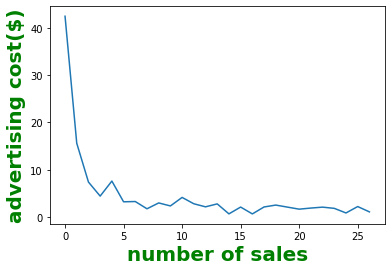

In [109]:
plt.plot(kjamz)
plt.xlabel('number of sales',fontsize = 20, weight = 'bold',color='green')
plt.ylabel('advertising cost($)',fontsize = 20, weight = 'bold',color='green');

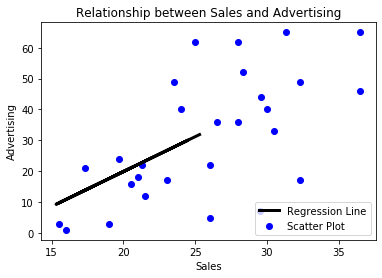

In [111]:
y_pred=lm.predict(X_test)


plt.scatter(X, y, color = 'blue', label='Scatter Plot')
plt.plot(X_test, y_pred, color = 'black', linewidth=3, label = 'Regression Line')
plt.title('Relationship between Sales and Advertising')
plt.xlabel('Sales')
plt.ylabel('Advertising')
plt.legend(loc=4)
plt.show()

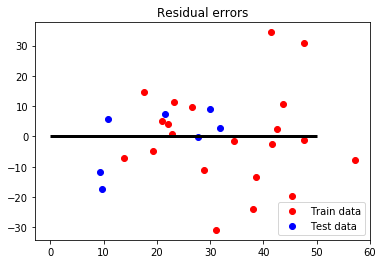

In [112]:
plt.scatter(lm.predict(X_train), lm.predict(X_train) - y_train, color = 'red', label = 'Train data')
plt.scatter(lm.predict(X_test), lm.predict(X_test) - y_test, color = 'blue', label = 'Test data')
plt.hlines(xmin = 0, xmax = 50, y = 0, linewidth = 3)
plt.title('Residual errors')
plt.legend(loc = 4)
plt.show()